Question 1
==

In [1]:
β=0.95; T=20; μ=1; Σ_0=0.5; R=0.5;

Let's calculate the $\Sigma$ values:

In [2]:
Σ = zeros(T+2) #Σ[1] is Σ_0, Σ[22] is Σ_21
Σ[1] = Σ_0
for t in 2:T+2
    Σ[t] = (1-Σ[t-1]/(Σ[t-1]+R))*Σ[t-1]*(1-Σ[t-1]/(Σ[t-1]+R)) + Σ[t-1]/(Σ[t-1]+R)*R*Σ[t-1]/(Σ[t-1]+R)
end

To find the reservation wage I write the equation into one function and look for its root:

In [3]:
using Distributions
using Roots

function init_res(Σ, m_next, Q)
    return function eval_equation(m) 
        equation = m + β*(  β*Q*cdf(Normal(m,Σ), m_next) 
                + 1/(1-β)*mean(Truncated(Normal(m,Σ), m_next, Inf))*(1-cdf(Normal(m,Σ), m_next))  ) - β*Q
        
        return equation < Inf ? equation : -5 #the truncated normal returns Inf if a division by zero occurs
    end
end 

init_res (generic function with 1 method)

In [4]:
function iterate_Q(Q)
    θ=zeros(T+2) #θ[1] is θ_0 the reservation wage in t=0
    θ[22] = (1-β)*β*Q

    for t in reverse(collect(2:(T+2)))
        θ[t-1] = fzero(init_res(Σ[t], θ[t], Q), θ[t]*1/2, 2)
        if abs(θ[t-1]-θ[t]*1/2)<1e-02
            println("bracket is wrong!")
            println(t)
            println(Q)
        end
    end
    
    return β*Q*cdf(Normal(μ,Σ_0), θ[1]) + 1/(1-β)*mean(Truncated(Normal(μ,Σ_0), θ[1], Inf))*(1-cdf(Normal(μ,Σ_0), θ[1]))
end

iterate_Q (generic function with 1 method)

In [5]:
Q_forward = [iterate_Q(Q) for Q in collect(linspace(18,30,100))];

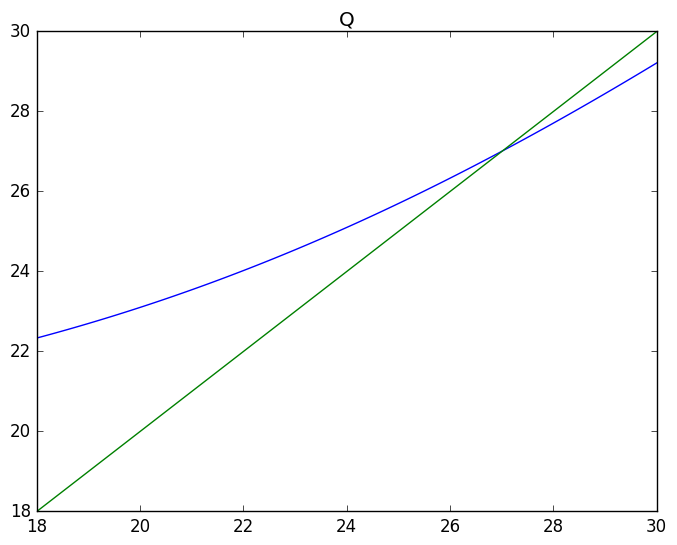

In [6]:
using PyPlot
plot(linspace(18,30,100), Q_forward)
plot(linspace(18,30,100),linspace(18,30,100))
title("Q");

In [7]:
fzero(Q -> Q - iterate_Q(Q),24,28)

27.01287409873506

In [8]:
Q=27.01287409873506;

In [9]:
θ_T1 = (1-β)*β*Q

1.2831115196899165

Period T's reservation wage:

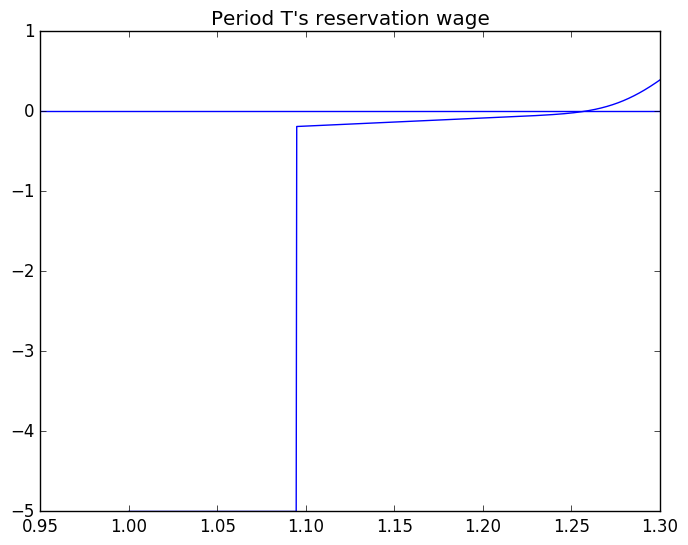

PyObject <matplotlib.text.Text object at 0x31cb2f4e0>

In [10]:
using PyPlot
plot(linspace(1,1.3,1000), [init_res(Σ[22],θ_T1,Q)(t) for t in collect(linspace(1,1.3,1000))])
axhline(0);
title("Period T's reservation wage")

In [17]:
θ=zeros(T+2) #θ[1] is θ_0 the reservation wage in t=0
θ[22] = (1-β)*β*Q

for t in reverse(collect(2:(T+2)))
    θ[t-1] = fzero(init_res(Σ[t],θ[t],Q),θ[t]*1/2,1.3)
    if abs(θ[t-1]-θ[t]*1/2)<1e-02
        println("bracket is wrong!")
        println(t)
    end
end

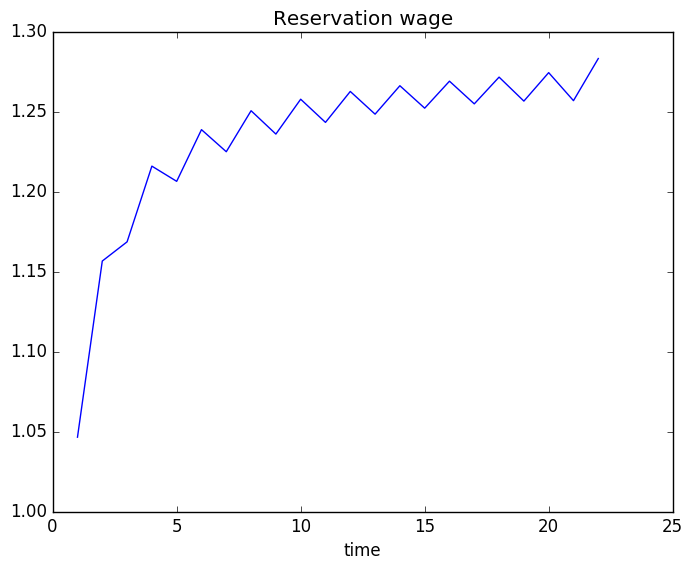

In [18]:
plot(1:length(θ),θ);
title("Reservation wage")
xlabel("time");

In [19]:
Q_new = β*Q*cdf(Normal(μ,Σ_0), θ[1]) + 1/(1-β)*mean(Truncated(Normal(μ,Σ_0), θ[1], Inf))*(1-cdf(Normal(μ,Σ_0), θ[1]))

27.012874098735058

Q was correct!

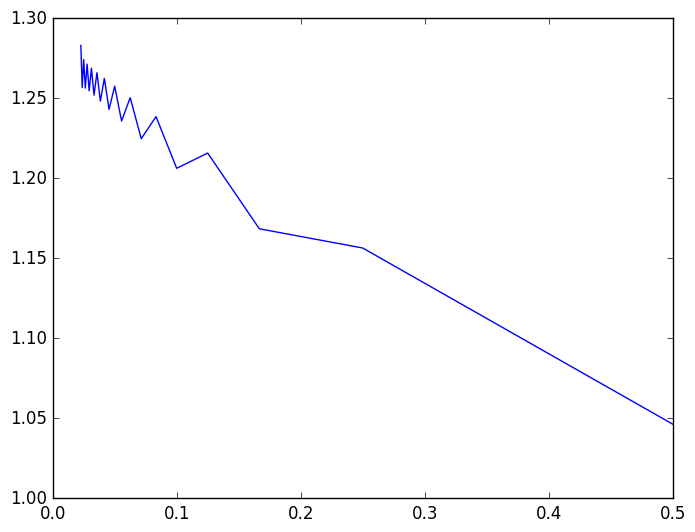

In [20]:
plot(Σ,θ);

Now let's fix period T, vary $\Sigma_T$ and find the reservation wage:

In [21]:
wage(σ) = fzero(init_res(σ, θ[22], Q), (1-β)*β*Q*1/2, 2)

wage (generic function with 1 method)

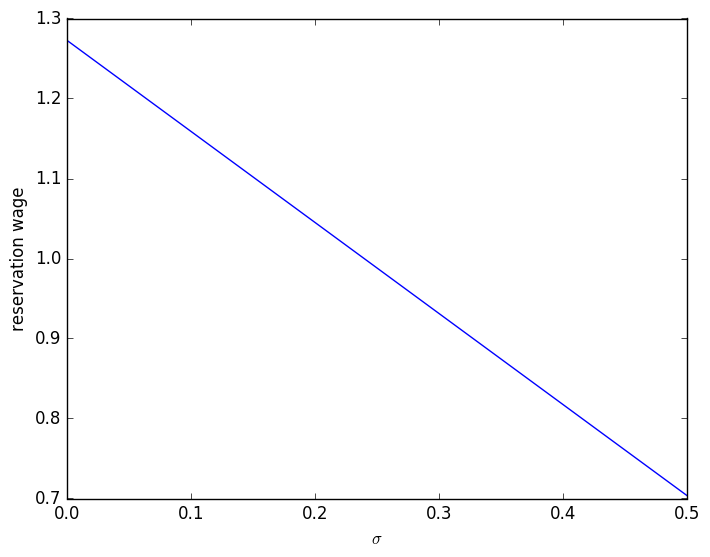

In [24]:
plot(linspace(0.001,0.5,1000),[wage(σ) for σ in linspace(0.01,0.5,1000)]);
ylabel("reservation wage")
xlabel(L"$\sigma$");

Wow, that looks quite linear!

Question 2
==
7.1
--
c.
--

In [98]:
using QuantEcon
using PyPlot

In [80]:
A0=100.; A1=0.05; β=0.95; d=10.; H0=95.5; H1=0.95;
competitive = LQ(d/2, [0 A1/2 -A0/2; A1/2 0 0;-A0/2 0 0], 
    [1 0 0; 0 H1 H0; 0 0 1], [1.0, 0.0, 0.0]; bet = β)
stationary_values!(competitive);
-competitive.F[3], 1 - competitive.F[1], -competitive.F[2]

(96.94871794872053,1.0000000000000024,-0.04628205128205243)

$y_{t+1}=96.949+y_t−0.046 \cdot Y_t$.
d.
--
With n identical firms, $Y_{t+1} = n \cdot y_{t+1} = n \cdot 96.949 + (1-n \cdot 0.046)\cdot Y_t$
7.2
--
a.
--

In [67]:
beliefs = ([94.0888, 0.9211], [93.22, 0.98433], [95.08187459215024, 0.95245906270392])

([94.0888,0.9211],[93.22,0.98433],[95.0819,0.952459])

In [68]:
for (H0, H1) in beliefs
    A = [1 0 0; 0 H1 H0; 0 0 1]
    rational = LQ(d/2, [0 A1/2 -A0/2; A1/2 0 0;-A0/2 0 0], 
        A, [1.0, 0.0, 0.0]; bet = β)
    stationary_values!(rational)
    hh = h0, h1, h2 = -rational.F[3], 1 - rational.F[1], -rational.F[2]
    
    println(maximum(abs([h0-H0, h1-H1])))
end



24.377960033616603
39.702935587528096
0.04754093729608244


The last one seems quite close to a rational expectations equilibrium.
7.3
--
b.
--

In [69]:
welfare = LQ(d/2, [A1/2 -A0/2; -A0/2 0], eye(2), [1.0, 0.0]; bet = β)
stationary_values!(welfare);
-welfare.F[2], 1 - welfare.F[1]

(95.08187459215002,0.9524590627039248)

c.
--
Those are the equilibrium values of the third belief in 7.2.a.
Steady State
--
$Y_{t+1} = 95.08 + 0.952 Y_t$ yields a steady state of:

In [87]:
Ybar = 95.08187459215002/(1-0.9524590627039248)

1999.999999999991

7.4.
--
b.
--

In [70]:
monopoly = LQ(d/2, [A1 -A0/2; -A0/2 0], eye(2), [1.0, 0.0]; bet = β)
stationary_values!(monopoly);
-monopoly.F[2], 1 - monopoly.F[1]

(73.47294403502833,0.9265270559649701)

Output is much lower!
7.5.
--
c.
--

In [84]:
A  = eye(3)
B1 = [0; 1.; 0]
B2 = [0; 0; 1.]
R1 = [0. -A0/2 0.; -A0/2 A1  A1/2.; 0 A1/2 0]
R2 = [0 0 -A0/2; 0 0 A1/2; -A0/2 A1/2 A1]
Q1 = d
Q2 = d
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

F1, F2, P1, P2 = nnash(A, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2, beta=β);

-F1

1×3 Array{Float64,2}:
 42.6809  -0.0434265  -0.0168511

In [85]:
-F2

1×3 Array{Float64,2}:
 42.6809  -0.0168511  -0.0434265

$q_{1,t+1} = 42.68 + (1-0.043) q_{1,t} - 0.017 q_{2,t}$

Trajectories
--
Duopolists calculations:

In [107]:
AF = A - B1*F1 - B2*F2
n = 100
x = zeros(3, n)

x[:, 1] = [1, Ybar*0.9/2, Ybar*0.9/2]
for t in 1:99
    x[:, t+1] = AF * x[:,t]
end
qlow = x[2, :] + x[3, :]

x[:, 1] = [1, Ybar*1.1/2, Ybar*1.1/2]
for t in 1:99
    x[:, t+1] = AF * x[:,t]
end
qhigh = x[2, :] + x[3, :];

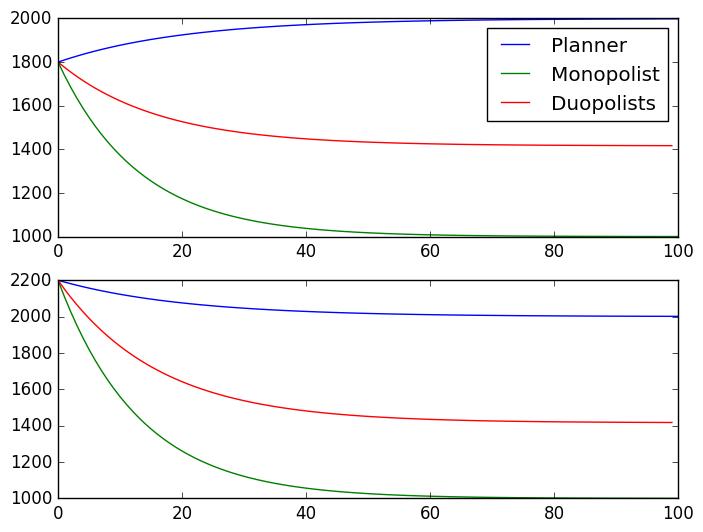

In [109]:
subplot(211)
plot(compute_sequence(welfare,[Ybar*0.9; 1])[1][1,:], label="Planner")
plot(compute_sequence(monopoly,[Ybar*0.9; 1])[1][1,:], label="Monopolist")
plot(qlow, label="Duopolists")
legend(loc="top right")
subplot(212)
plot(compute_sequence(welfare,[Ybar*1.1; 1])[1][1,:])
plot(compute_sequence(monopoly,[Ybar*1.1; 1])[1][1,:]);
plot(qhigh);

The planner generates the highest output, the monopolist the lowest. The competition among the duopolists yields an output inbetween.